## Краткое описание

Использование fine-tuned модели VggFace для классификации лиц [ilapro53/vggface_model_ft_check/keras/ep60](https://www.kaggle.com/models/ilapro53/vggface_model_ft_check/keras/ep60)

Ноутбук с обучением модели: [ilapro53/5dfc1-vgg-face-py3-6-6-training](https://www.kaggle.com/code/ilapro53/5dfc1-vgg-face-py3-6-6-training)

**Версия Python:** Python 3.6.6 (На основе ноутбука: [czy111/python 3.6.6](https://www.kaggle.com/code/czy111/python-3-6-6?scriptVersionId=166908451))

## Preparation

In [ ]:
!mkdir output/

In [2]:
# Версия Python
!python --version > output/python_version.txt
!cat output/python_version.txt

Python 3.6.6 :: Anaconda, Inc.


In [3]:
%%capture pip_install_log
!pip install gdown
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [4]:
import warnings

with open('output/pip_install_stdout.log', 'w') as f:
    f.write(pip_install_log.stdout)

with open('output/pip_install_stderr.log', 'w') as f:
    f.write(pip_install_log.stderr)
    
if pip_install_log.stderr != '':
    warnings.warn(pip_install_log.stderr)

In [5]:
!ls output/

pip_freeze.txt		pip_install_stdout.log
pip_install_stderr.log	python_version.txt


In [6]:
!pip freeze > output/pip_freeze.txt

In [7]:
# Импорты tensorflow, keras, keras_vggface

from tensorflow import config as tf_config
from tensorflow import __version__ as __tf_version__

physical_devices = tf_config.list_physical_devices('GPU')
print("GPUs Available: ", physical_devices)

for device in physical_devices:
    tf_config.experimental.set_memory_growth(device, True)

import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

print('keras backend: ', K.backend())
print("keras version: ", keras.__version__)
    
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

print("TF version: ", __tf_version__)

GPUs Available:  []
keras backend:  tensorflow
keras version:  2.3.1
TF version:  2.1.0


Using TensorFlow backend.


In [8]:
# Другие импорты

import os
from pathlib import Path, PurePath
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gdown
import os

## Load data

In [28]:
# Задаем пути и ссылки

csv_sm_sbm_path = "/kaggle/input/skillbox-computer-vision-project/sample_submission.csv"
csv_train_path = "/kaggle/input/skillbox-computer-vision-project/train.csv"

data_zip_url = "https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing"
data_zip_path = "data.zip"
data_folder_path = "./data"

test_zip_url = "https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing"
test_zip_path = "test_kaggle.zip"
test_folder_path = "./test_kaggle"

train_folder_path = "./train_data"
# test_folder_path = "./test_data"

In [10]:
!ls

data  data.zip	output	test_data


In [29]:
# Скачивание данных
if not os.path.exists(data_zip_path):
    gdown.download(data_zip_url, data_zip_path, fuzzy=True)
    
# Скачивание данных
if not os.path.exists(test_zip_path):
    gdown.download(test_zip_url, test_zip_path, fuzzy=True)

In [30]:
!ls

data  data.zip	output	test_kaggle  test_kaggle.zip


In [31]:
# Распаовка данных
if not os.path.exists(data_folder_path):
    print(f'Unpacking {data_zip_path}...')
    shutil.unpack_archive(data_zip_path, '.', 'zip')
    shutil.move('./train', data_folder_path)

if not os.path.exists(test_folder_path):
    print(f'Unpacking {test_zip_path}...')
    shutil.unpack_archive(test_zip_path, '.', 'zip')
#     shutil.move('./test', test_folder_path)

print('Done!')

Done!


In [32]:
!ls /kaggle/input

kaggle-key  skillbox-computer-vision-project  vggface_model_ft_check


In [26]:
!ls

data  data.zip	output	test_kaggle  test_kaggle.zip


In [62]:
def reformat_path(path):
    return str(test_folder_path / PurePath(path))

reformat_path('<file_name>')

'test_kaggle/<file_name>'

In [63]:
test_kaggle_df = pd.DataFrame(
    {'image_path': os.listdir(test_folder_path)}
)
print(test_kaggle_df.shape)
test_kaggle_df['image_path'] = test_kaggle_df['image_path'].apply(reformat_path)
test_kaggle_df.head()

(5000, 1)


,image_path
0,test_kaggle/4653.jpg
1,test_kaggle/2461.jpg
2,test_kaggle/3955.jpg
3,test_kaggle/4022.jpg
4,test_kaggle/2246.jpg


## Data Preparation

In [47]:
test_folder_path

'./test_kaggle'

In [48]:
!ls

data  data.zip	output	test_kaggle  test_kaggle.zip


In [69]:
def build_test_generator(val=test_kaggle_df, batch_size=128, image_size=16, preprocessing_function_val=None):
    
    val['image_path'] = val['image_path'].dropna().apply(str)
    
    val_image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function_val)

    val_generator = val_image_generator.flow_from_dataframe(dataframe=val,
                                                            directory='.',
                                                            x_col='image_path',
#                                                             y_col='emotion',
                                                            target_size=(image_size, image_size),
                                                            batch_size=batch_size,
                                                            class_mode=None,
                                                            shuffle=False,
                                                            interpolation='nearest',
                                                            validate_filenames=True)

    return val_generator

## Defining model

In [65]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [49]:
# vggface_model.summary()

In [51]:
vggface_model.trainable = False
vggface_model_ft = keras.models.Sequential([
    vggface_model,
    keras.layers.Flatten(input_shape=(None, None, 2048)),
    keras.layers.Dense(9, activation='softmax')
])

In [52]:
vggface_model_ft.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 18441     
Total params: 23,579,593
Trainable params: 18,441
Non-trainable params: 23,561,152
_________________________________________________________________


In [53]:
def preprocess_vgg_val(image_):
    preprocessed_image = utils.preprocess_input(image_, version=2)
    return preprocessed_image

In [71]:
val_gen = build_test_generator(image_size=224,
                               batch_size=128,
                               preprocessing_function_val=preprocess_vgg_val
                              )

Found 5000 validated image filenames.


In [72]:
vggface_model_ft.load_weights("/kaggle/input/vggface_model_ft_check/keras/ep60/1/vggface_model_ft_check_ep60.hdf5")

In [73]:
vggface_model_ft.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [75]:
# vggface_model_ft.evaluate(val_gen)

## Predictions

In [76]:
predictions = vggface_model_ft.predict(val_gen, verbose=1)

40/40 [==============================] - 748s 19s/step


In [78]:
LABELS_AND_INDICES = (
    ('anger', 0),
    ('contempt', 1),
    ('disgust', 2),
    ('fear', 3),
    ('happy', 4),
    ('neutral', 5),
    ('sad', 6),
    ('surprise', 7),
    ('uncertain', 8),
)

LABELS_TO_INDICES = dict(LABELS_AND_INDICES)
INDICES_TO_LABELS = dict((y, x) for x, y in LABELS_AND_INDICES)

INDICES_TO_LABELS, LABELS_TO_INDICES

({0: 'anger',
  1: 'contempt',
  2: 'disgust',
  3: 'fear',
  4: 'happy',
  5: 'neutral',
  6: 'sad',
  7: 'surprise',
  8: 'uncertain'},
 {'anger': 0,
  'contempt': 1,
  'disgust': 2,
  'fear': 3,
  'happy': 4,
  'neutral': 5,
  'sad': 6,
  'surprise': 7,
  'uncertain': 8})

In [79]:
def predictions_to_indices(predictions: np.array):
    return predictions.argmax(axis=1)

def indices_to_labels(predictions: np.array):
    to_indices = np.vectorize(lambda i: INDICES_TO_LABELS[i])
    return to_indices(predictions)

def predictions_to_labels(predictions: np.array):
    indices = predictions_to_indices(predictions)
    labels = indices_to_labels(indices)
    return labels

In [80]:
def prediction_to_index(prediction: int):
    return prediction.argmax()

In [81]:
np.save('predictions.npy', predictions)

In [82]:
predictions = np.load('predictions.npy')

In [83]:
predictions.shape

(5000, 9)

In [84]:
predictions_labels = predictions_to_labels(predictions)
predictions_labels[:10]

array(['surprise', 'happy', 'anger', 'happy', 'sad', 'anger', 'uncertain',
       'sad', 'sad', 'sad'], dtype='<U9')

### Predictions visualization

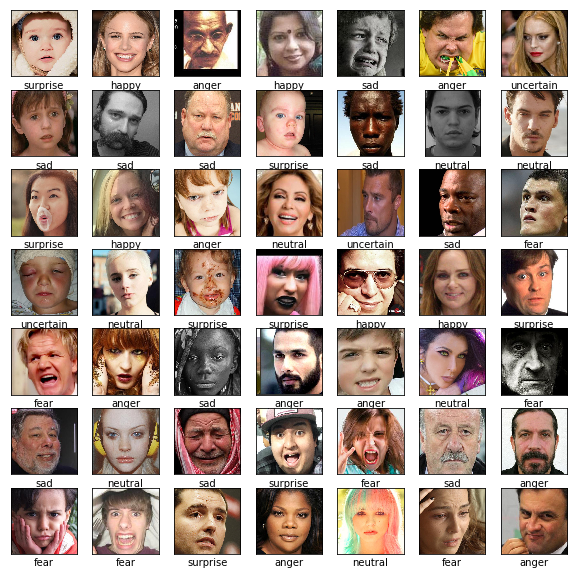

In [86]:
w, h = 10, 10
columns, rows = 7, 7

fig = plt.figure(figsize=(10, 10))
fig.set_facecolor('white')

data_iterator = test_kaggle_df.iterrows()

for i in range(1, columns*rows +1):
    img = mpimg.imread(next(data_iterator)[1]['image_path'])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(predictions_labels[i-1])
    
plt.show()

In [87]:
!ls

data  data.zip	output	predictions.npy  test_kaggle  test_kaggle.zip


In [89]:
test_kaggle_df.head()

,image_path
0,test_kaggle/4653.jpg
1,test_kaggle/2461.jpg
2,test_kaggle/3955.jpg
3,test_kaggle/4022.jpg
4,test_kaggle/2246.jpg


In [90]:
test_kaggle_df['emotion_prediction'] = predictions_labels
test_kaggle_df.head()

,image_path,emotion_prediction
0,test_kaggle/4653.jpg,surprise
1,test_kaggle/2461.jpg,happy
2,test_kaggle/3955.jpg,anger
3,test_kaggle/4022.jpg,happy
4,test_kaggle/2246.jpg,sad


In [92]:
test_kaggle_df['emotion_prediction'].shape

(5000,)

In [94]:
kaggle_submission = test_kaggle_df[['image_path', 'emotion_prediction']].rename({'emotion_prediction': 'emotion'}, axis=1)
kaggle_submission['image_path'] = kaggle_submission['image_path'].apply(lambda path: Path(path).parts[-1])
kaggle_submission

,image_path,emotion
0,4653.jpg,surprise
1,2461.jpg,happy
2,3955.jpg,anger
3,4022.jpg,happy
4,2246.jpg,sad
...,...,...
4995,833.jpg,surprise
4996,3231.jpg,sad
4997,284.jpg,fear
4998,1804.jpg,neutral


In [95]:
kaggle_submission['image_path'].nunique()

5000

In [96]:
kaggle_submission.to_csv('submission.csv', index=False)

In [97]:
!head submission.csv

image_path,emotion
4653.jpg,surprise
2461.jpg,happy
3955.jpg,anger
4022.jpg,happy
2246.jpg,sad
3679.jpg,anger
4633.jpg,uncertain
3292.jpg,sad
2850.jpg,sad


In [ ]:
%%capture
!pip install kaggle
!cp /kaggle/input/kaggle-key/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [103]:
!kaggle competitions submit \
    -c skillbox-computer-vision-project \
    -f submission.csv \
    -m "2-й сабмит. Автор: Илья Пироженко."

100%|███████████████████████████████████████| 76.9k/76.9k [00:00<00:00, 196kB/s]
Successfully submitted to Skillbox. Дипломная работа по компьютерному зрению